ADS Sample Notebook. 

Copyright (c) 2019 Oracle, Inc.  All rights reserved. Licensed under the Universal Permissive License v 1.0 as shown at https://oss.oracle.com/licenses/upl.

***
# <font color=red>Building a Classifier using AutoML</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color=teal> Oracle ADS Team </font></p>

***

## Overview of this Notebook

In this notebook we will build a classifier using the Oracle AutoML tool for the public wine dataset. The wine dataset is a multiclass classification dataset, based on results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of 13 constituents found in each of the three types of wines. More details about the dataset can be found at https://archive.ics.uci.edu/ml/datasets/wine.

We will explore the various options provided by the Oracle AutoML tool, allowing the user to exercise control over the AutoML training process. We will finally evaluate the different models trained by Oracle AutoML using the handy ADSEvaluator class.

---
## Prerequisites:

  - Experience level: Novice (Python and Machine Learning)
  - Professional experience: Some industry exprience
---

## Business Use:

Data analytics and modeling problems using machine learning are becoming popular and often rely on data science expertise to build accurate Machine Learning (ML) or Deep Learning (DL) models. Such modeling tasks primarily involve the following steps:
- Pick an appropriate model for the given dataset and prediction task at hand,
- Tune the chosen model’s hyperparameters for the given dataset.
- Reduce the dataset size using feature selection to reduce the overall runtime of the machine learning tasks and improve model scores.

All of these steps are significantly time consuming and ad-hoc in nature that heavily rely on data scientist expertise. Unfortunately, to make this problem harder, the best feature subset, model, and hyperparameter choice widely varies with the dataset and the prediction task. Hence, there is no one-size-fits-all solution to achieve reasonably good model performance. Using a simple Python API, AutoML can quickly (faster) jump-start the datascience process with a good tuned model (accurate) with appropriate features for a given prediction task.

## Objectives:

This nodebook will be useful to you if you want to understand how to:

- <a href='#setup'>0. Setup</a>
- <a href='#load'>1. Load a Dataset</a> from scikit-learn through ADS
- <a href='#provider'>2. Create an Instance of OracleAutoMLProvider</a>
- <a href='#default'>3. Train a Model</a> using Oracle AutoML
- <a href='#modellist'>4. Provide a Specific Model List</a> to Oracle AutoML
- <a href='#scoringstr'>5. Specify a Different Scoring Metric</a> to Oracle AutoML
- <a href='#scoringfn'>6. Specify a User-defined Scoring Function</a> to Oracle AutoML
- <a href='#eval'>7. Compare Different Generated Models</a>
- <a href='#save'>8. Save Models to Your Catalog</a>
- <a href='#ref'>References</a>

Load necessary modules

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

from ads.dataset.dataset_browser import DatasetBrowser
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML

Using TensorFlow backend.


<a id='load'></a>
## Load a scikit-learn dataset using ADS
We start by reading in the wine dataset from sklearn. The ADS DatasetBrowser allows us to easily work with scikit-learn datasets. The .set_target() API specifies the name of the target column in the dataset, which in the case of the wine dataset is called "target".

In [5]:
ds = DatasetBrowser.sklearn().open("wine").set_target("target")

Lets look at a few of the values in the data

In [3]:
ds.head()

alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline   target  
0                          3.92   1065.0  class_0  
1                          3.40   1050.0  class_0  
2                          3.17   1185.0  class_0  
3                          3.45   1480.0  class_0  
4                          2.93    735.0  class_0

The wine dataset contains a mix of continuous and categorical data.

In [4]:
ds.summary()

Feature              Datatype
0                         target  categorical/category
1                        alcohol    continuous/float64
2                     malic_acid    continuous/float64
3                            ash    continuous/float64
4              alcalinity_of_ash    continuous/float64
5                      magnesium       ordinal/float64
6                  total_phenols    continuous/float64
7                     flavanoids    continuous/float64
8           nonflavanoid_phenols    continuous/float64
9                proanthocyanins    continuous/float64
10               color_intensity    continuous/float64
11                           hue    continuous/float64
12  od280/od315_of_diluted_wines    continuous/float64
13                       proline       ordinal/float64

We check if the dataset has any missing values. The Oracle AutoML solution automatically handles missing values by intelligently dropping features with too many missing values, and filling in the remaining missing values based on the feature type.

In [5]:
ds.isna().sum()

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
target                          0
dtype: int64

We visualize the distribution of the target variable. The dataset has 3 classes, class_0, class_1 and class_2, identifying the specific cultivar responsible for a wine.

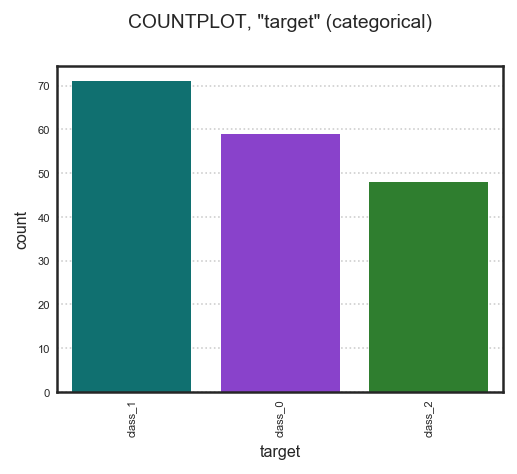

In [6]:
ds.target.show_in_notebook()

ADS provides an ability to split a dataset into train and test sets. We create an 80-20 split, where we reserve 20% of the data as the test set to evaluate the model on unseen data.

In [7]:
train, test = ds.train_test_split(test_size=0.2)
[train.X.shape, test.X.shape]

[(141, 13), (37, 13)]

<a id='provider'></a>
## Create an instance of OracleAutoMLProvider

The Oracle AutoML solution automatically provides a tuned ML pipeline that best models the given a training dataset and a prediction task at hand. Here the dataset can be any supervised prediction task, e.g. classification or regression where the target can be a simple binary or a multi-class value or a real valued column in a table, respectively).

The Oracle AutoML solution is selected using the `OracleAutoMLProvider` object that delegates model training to the AutoML package.

AutoML consists three main modules 
- Algorithm Selection - Identify the right algorithm for a given dataset, choosing from amongst
    - AdaBoostClassifier
    - DecisionTreeClassifier
    - ExtraTreesClassifier
    - KNeighborsClassifier
    - LGBMClassifier
    - LinearSVC
    - LogisticRegression
    - RandomForestClassifier
    - SVC
    - XGBClassifier
- Adaptive Sampling - Choose the right subset of samples for evaluation, trying to balance classes at the same time
- Feature Selection - Choose the right set of features that maximize score for the chosen algorithm
- Hyperparameter Tuning - Find the right model parameters that maximize score for the given dataset. 

All these pieces are readily combined into a simple AutoML pipeline which automates the entire Machine Learning process with minimal user input/interaction.

The OracleAutoMLProvider class supports 2 arguments:
- n_jobs: Specifies the degree of parallelism for Oracle AutoML. -1 (default) means that AutoML will use all available cores.
- loglevel: The verbosity of output for Oracle AutoML. Can be specified using the Python logging module (https://docs.python.org/3/library/logging.html#logging-levels).
    
We create an OracleAutoMLProvider object that uses all available cores, and disable any logging.

In [8]:
ml_engine = OracleAutoMLProvider(n_jobs=-1, loglevel=logging.ERROR)

<a id='default'></a>
## Train a model using Oracle AutoML

The ADS AutoML API is quite simple to work with. We create an instance of AutoML (oracle_automl) with the provider set to the OracleAutoMLProvider, and passing in the training data (train). We then invoke the AutoML optimizer by calling train(). This does 2 things:
- Look at the training data, and and identify the best set of features, the best algorithm and the best set of hyperparameters for this data. A model is then generated, trained on this data and returned (automl_model1)
- A baseline model is also generated on this training data using the Zero Rule algorithm. For a classification predictive modeling problem where a categorical value is predicted, the Zero Rule algorithm predicts the class value that has the most observations in the training dataset.

In [9]:
oracle_automl = AutoML(train, provider=ml_engine)
automl_model1, baseline = oracle_automl.train()

2019-10-31 11:29:30,972 automl.models Model (LGBMClassifier) not found


At the end of train, OracleAutoMLProvider outputs a summary of the optimization process, such as
- Information about the training data 
- Information about the AutoML Pipeline such as selected features that AutoML found to be most predictive in the training data, the selected algorithm that was the best choice for this data, and the model hyperparameters for the selected algorithm
- A summary of the different trials that AutoML performs in order to identify the best model

Oracle AutoML's Pipeline automates a lot of the datascience process, trying out a lot of different machine learning parameters quickly in a parallel fashion. The model provides a print_trials API to output all the different trials performed by Oracle AutoML. The API has 2 arguments
- max_rows: Specifies the total number of trials that will be printed. By default, all trials are printed.
- sort_column: Column to sort results by. Must be one of 
    - Algorithm
    - #Samples
    - #Features
    - Mean Validation Score
    - Hyperparameters
    - CPU Time

In [10]:
oracle_automl.print_trials(max_rows=20, sort_column='Mean Validation Score')

We also provide the capability to visualization the results of each stage of the AutoML pipeline. The plot below shows the scores predicted by Algorithm Selection for each algorithm. The horizontal line shows the average score across all algorithms. Algorithms below the line are colored turquoise, whereas those with a score higher than the mean are colored teal. Here we can see that ExtraTreesClassifier achieved the highest predicted score (orange bar), and is chosen for subsequent stages of the Pipeline.

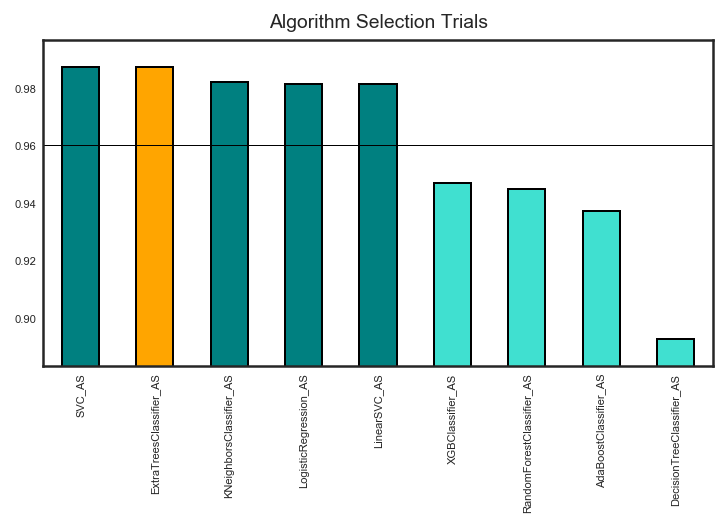

In [11]:
oracle_automl.visualize_algorithm_selection_trials()

Following Algorithm Selection, Adaptive Sampling aims to find the smallest dataset sample that can be created without compromising validation set score for the algorithm chosen (ExtraTreesClassifier). Given the small size of the training data (141 samples), Adaptive Sampling does not do anything here.

In [4]:
oracle_automl.visualize_adaptive_sampling_trials()

ERROR:ADS Exception
Traceback (most recent call last):
  File "/home/datascience/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-70fa1f1df46c>", line 1, in <module>
    oracle_automl.visualize_adaptive_sampling_trials()
NameError: name 'oracle_automl' is not defined
NameError: name 'oracle_automl' is not defined

After finding a sample subset, the next goal of Oracle AutoML is to find a relevant feature subset that maximizes score for the chosen algorithm. Oracle AutoML Feature Selection follows an intelligent search strategy, where it looks at various possible feature rankings and subsets, and identifies that smallest feature subset that does not compromise on score for the chosen algorithm (ExtraTreesClassifier). The orange line shows the optimal number of features chosen by Feature Selection (5 features - alcohol, flavanoids, color_intensity, hue, proline)

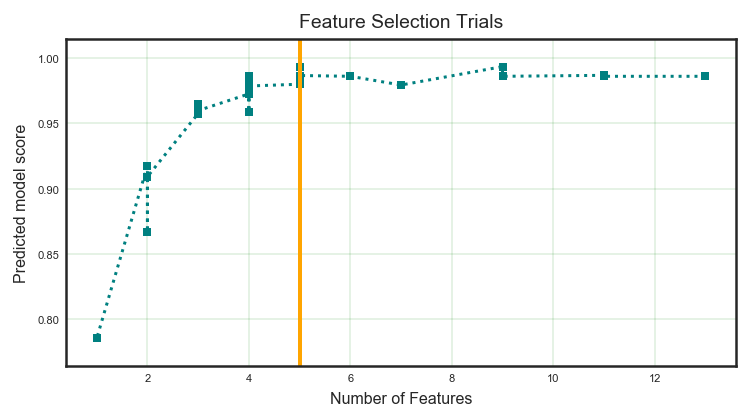

In [13]:
oracle_automl.visualize_feature_selection_trials()

Hyperparameter Tuning is the last stage of the Oracle AutoML pipeline, and focuses on improving the chosen algorithm's score on the reduced dataset (given by Adaptive Sampling and Feature Selection). We use a novel algorithm to search across many hyperparamter dimnesions, and converge automatically when optimal hyperparameters are identified. Each trial in the graph below represents a particular hyperparamter combination for ExtraTreesClassifier.

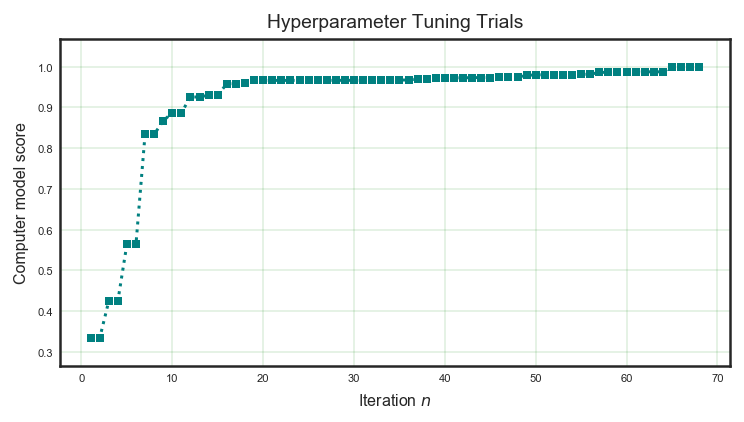

In [14]:
oracle_automl.visualize_tuning_trials()

<a id='modellist'></a>
## Provide a specific model list to Oracle AutoML
The Oracle AutoML solution also supports a model_list argument, allowing you to control the what algorithms AutoML considers during its optimization process. model_list is specified as a list of strings, which can be any combination of 
- AdaBoostClassifier
- DecisionTreeClassifier
- ExtraTreesClassifier
- KNeighborsClassifier
- LGBMClassifier
- LinearSVC
- LogisticRegression
- RandomForestClassifier
- SVC
- XGBClassifier
Here, we ask AutoML to only consider XGBoost Classifier, since we feel that it is a good algorithm for this dataset.

In [15]:
automl_model2, _ = oracle_automl.train(model_list=['XGBClassifier'])

<a id='scoringstr'></a>
## Specify a different scoring metric to Oracle AutoML
The Oracle AutoML tool tries to maximize a given scoring metric, by looking at different algorithms, features and hyperparameter choices. By default, the score metric is set to roc_auc for binary classifcation, recall_macro for multiclass classification, and neg_mean_squared_error for regression. 
The user can also provide their own scoring metric of interest using the score_metric argument, allowing AutoML to maximize using that metric. The scoring metric can be specified as a string
- For binary classification, one of 'roc_auc', 'accuracy', 'f1', 'precision', 'recall', 'f1_micro', 'f1_macro', 'f1_weighted', 'f1_samples', 'recall_micro', 'recall_macro', 'recall_weighted', 'recall_samples', 'precision_micro', 'precision_macro', 'precision_weighted', 'precision_samples'
- For multiclass classification, one of 'recall_macro', 'accuracy','f1_micro', 'f1_macro', 'f1_weighted', 'f1_samples', 'recall_micro', 'recall_weighted', 'recall_samples', 'precision_micro', 'precision_macro', 'precision_weighted', 'precision_samples'
- For regression, one of 'neg_mean_squared_error', 'r2', 'neg_mean_absolute_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error'

Here, we ask AutoML to optimize for the 'f1_macro' scoring metric.

In [16]:
automl_model3, _ = oracle_automl.train(score_metric='f1_macro')

2019-10-31 11:30:05,360 automl.models Model (LGBMClassifier) not found


<a id='scoringfn'></a>
## Specify a user defined scoring function to Oracle AutoML
Alternatively, the score_metric can also be specified as a user defined function of the form 

```
def score_fn(y_true, y_pred):
    logic here
    return score
```
The scoring function needs to be then encapsulated as a scikit-learn scorer using the make_scorer function. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html#sklearn.metrics.make_scorer

Here, we create leverage scikit-learn's implementation of the balanced accuracy scoring function. We then create a scorer function (score_fn) and pass it to the score_metric argument of train.

In [17]:
import numpy as np
from sklearn.metrics import make_scorer, f1_score

score_fn = make_scorer(f1_score, greater_is_better=True, needs_proba=False, average='macro')
automl_model4, _ = oracle_automl.train(score_metric=score_fn)

2019-10-31 11:30:07,681 automl.models Model (LGBMClassifier) not found


<a id='eval'></a>
## Compare different generated models
A model trained using AutoML can easily be deployed into production, as it behaves similar to any standard Machine Learning model. We now evaluate the model on unseen data stored in test. We rename each of the generated AutoML models making them easier to visualize. 
We use ADSEvaluator to visualize behavior for each of the models on the test set, including the baseline.

HTML(value='<style  type="text/css" >\n    #T_c443d7ba_fc0d_11e9_b7f2_38f9d3382bd9  {\n          text-align: r…

HTML(value='<style  type="text/css" >\n    #T_c44eb3ba_fc0d_11e9_9bb5_38f9d3382bd9  {\n          text-align: r…

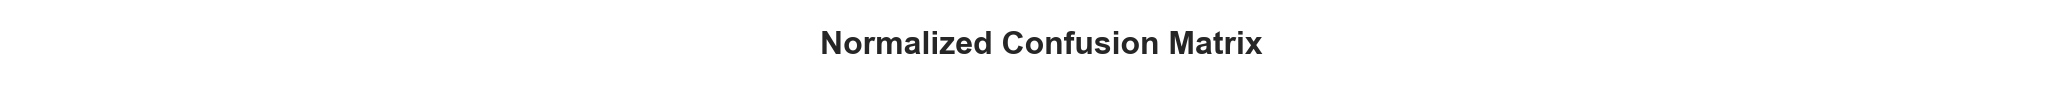

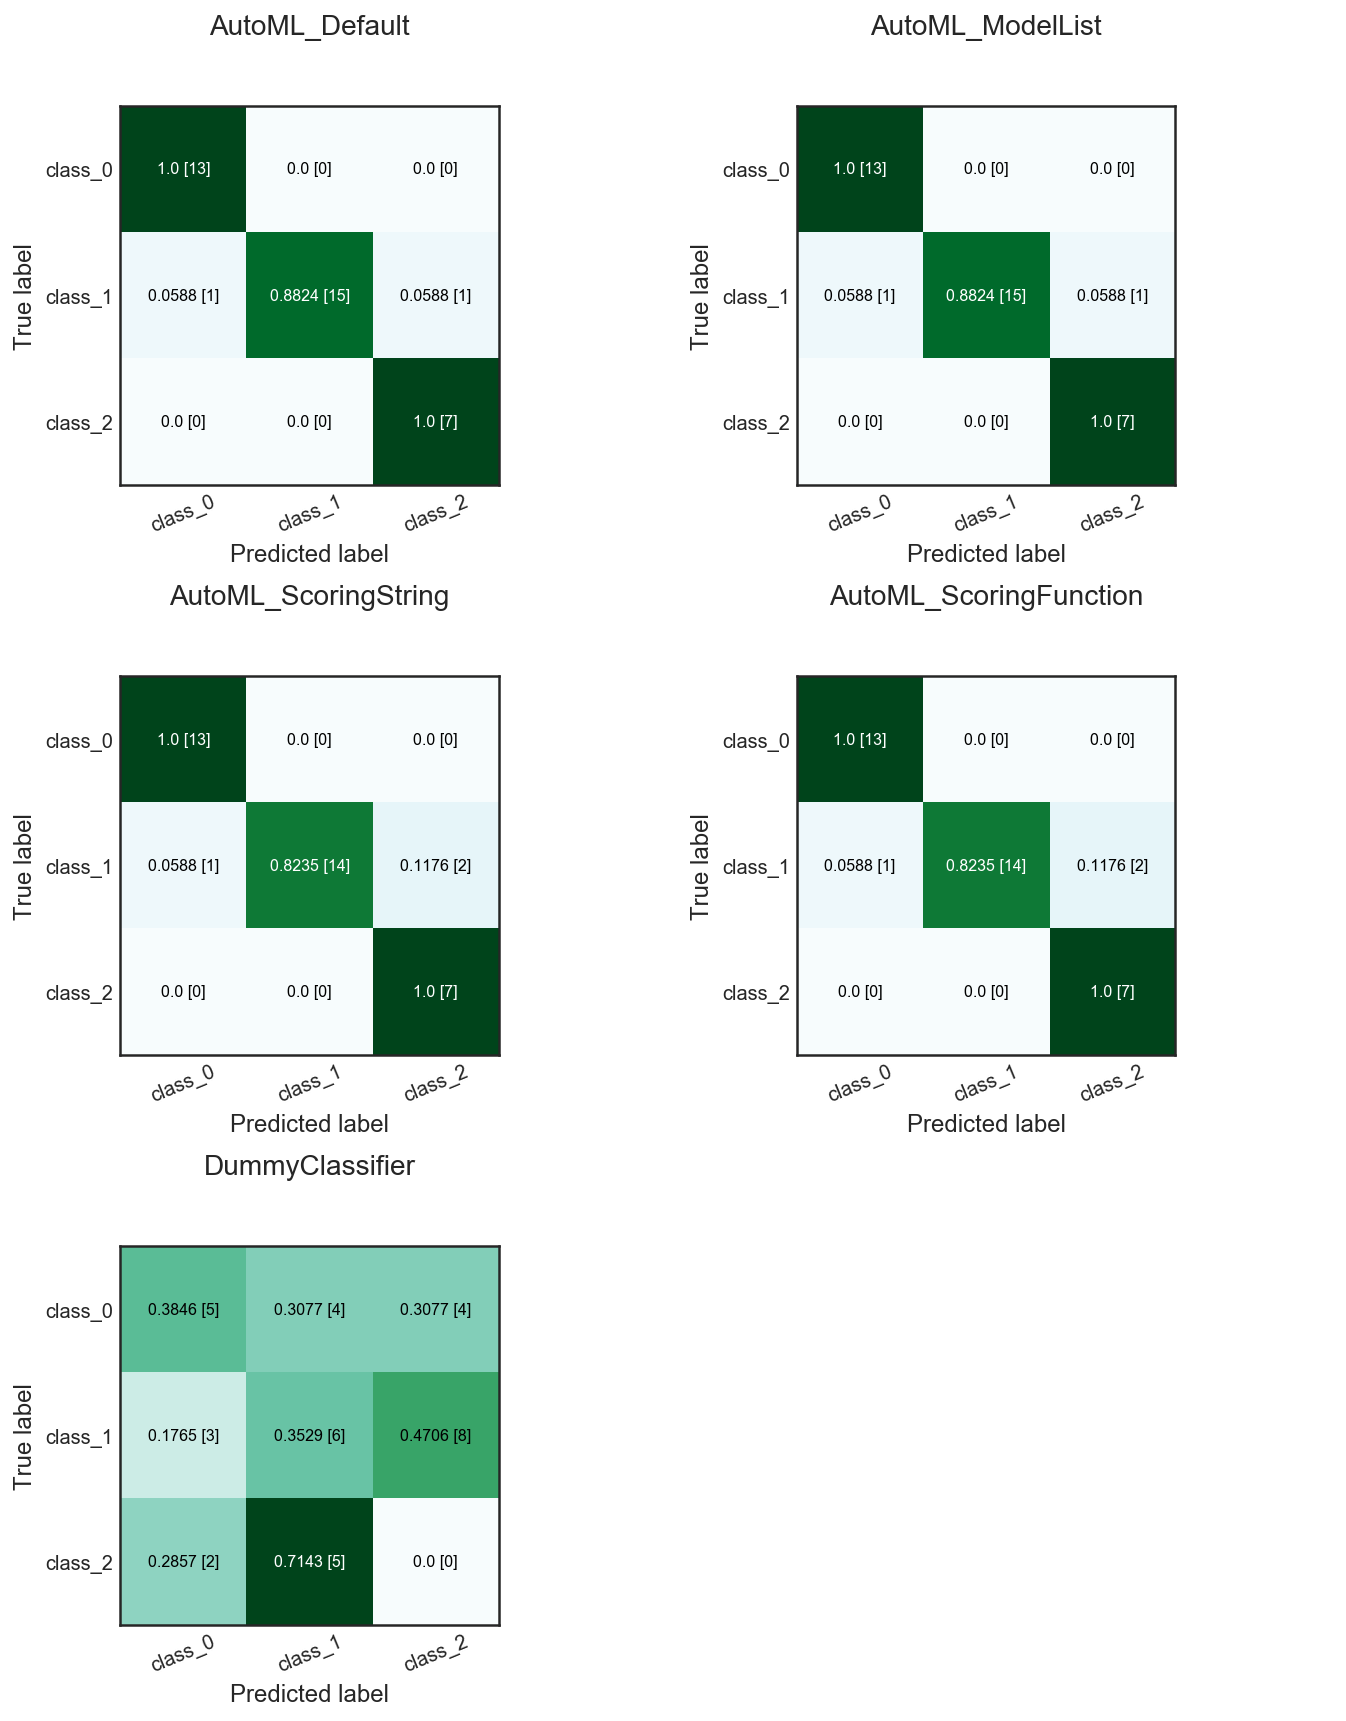

In [20]:
from ads.evaluations.evaluator import ADSEvaluator

automl_model1.rename('AutoML_Default')
automl_model2.rename('AutoML_ModelList')
automl_model3.rename('AutoML_ScoringString')
automl_model4.rename('AutoML_ScoringFunction')
evaluator = ADSEvaluator(test, models=[automl_model1, automl_model2, automl_model3, automl_model4, baseline], training_data=train)
evaluator.show_in_notebook(plots=['normalized_confusion_matrix'])
evaluator.metrics

In [ ]:
evaluator.test_evaluations

<a id='save'></a>
## Save Models to Your Catalog

After you have trained your model, you may want to save it for future use or implementation somewhere else. Let's walk through saving your model your current project and compartment. Let's pick the models we would like to save. Based off of our evaluations, AutoML Default and AutoML Model List performed best, so let's grab those two (`automl_model1`, `automl_model2`), and prepare them to be saved.

In [ ]:
from ads.catalog.model import ModelCatalog
from ads.catalog.project import ProjectCatalog
from ads.common.model_artifact import ModelArtifact

model_artifact1 = automl_model1.prepare("/tmp/model/", force_overwrite=True)
model_artifact2 = automl_model2.prepare("/tmp/model2/", force_overwrite=True)

First, let's get our Compartment and Project OCID's:

In [ ]:
import os
compartment_id = os.environ['NB_SESSION_COMPARTMENT_OCID']
project_id = os.environ["PROJECT_COMPARTMENT_OCID"]

Finally, we can save our model for future reloading:

In [ ]:
mc_model1 = model_artifact1.save(project_id=project_id, compartment_id=compartment_id, display_name="AutoML Default",
                               description="Default training on automl", 
                               training_script_path="ads_OracleAutoMLProvider_Classification_wine.ipynb", ignore_pending_changes=True)
mc_model2 = model_artifact2.save(project_id=project_id, compartment_id=compartment_id, display_name="AutoML Model List",
                                 description="training automl with a model list", 
                                 training_script_path="ads_OracleAutoMLProvider_Classification_wine.ipynb", ignore_pending_changes=True)
mc_model1

<a id='ref'></a>
## References

- scikit-learn https://scikit-learn.org/stable/